In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
%matplotlib inline

def show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change channels order since the YOLO work on BGR images


In [2]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')

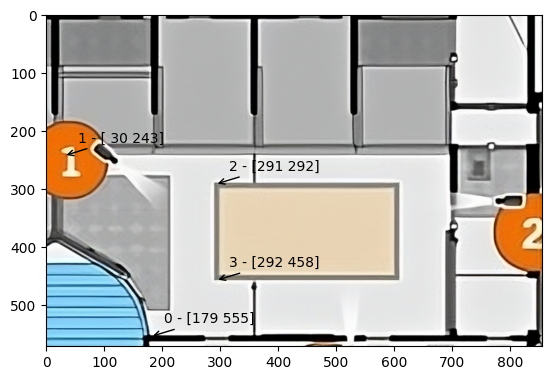

In [3]:
background = cv2.imread('back.jpeg')
show(background)
for i, pt in enumerate(MAP_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

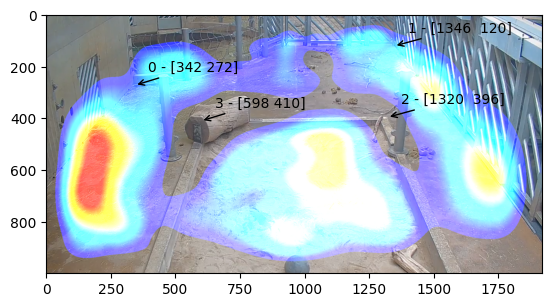

In [4]:
img = cv2.imread('heat.png')
show(img)
for i, pt in enumerate(IMAGE_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

572 856


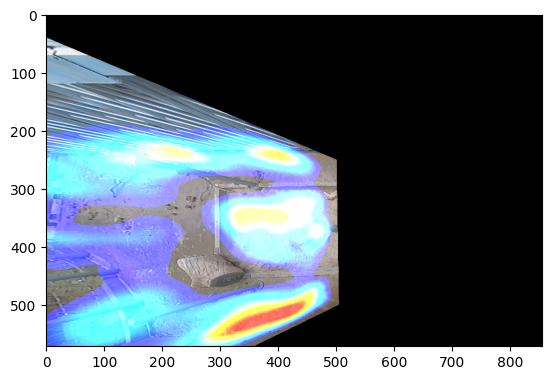

In [5]:
H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(img, H, (width, height))
show(dst)

In [6]:
def transform_row(M, x, y, width, height):
    x, y = x*1920, y*1000
    width, height = width*1920, height*1000
    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  # Reshape and ensure it's float32
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, H)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_prime, y_prime = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    left_prime = transform_point(M, left, y)
    right_prime = transform_point(M, right, y)
    width_prime = np.linalg.norm(np.array(left_prime)-np.array(right_prime))/1.5
    up, down = y - height/2, y + height/2
    up_prime = transform_point(M, x, up)
    down_prime = transform_point(M, x, down)
    height_prime = np.linalg.norm(np.array(up_prime)-np.array(down_prime))/1.5
    return x_prime/856, y_prime/572, width_prime/856, height_prime/572


In [7]:
df_new = pd.DataFrame(columns=['Camera', 'Date', 'X_center_prime', 'Y_center_prime', 'Width_prime', 'Height_prime'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    data['Date'] = row['Date']
    data['X_center_prime'], data['Y_center_prime'], data['Width_prime'], data['Height_prime'] = transform_row(H, row['X_center'], row['Y_center'], row['Width'], row['Height'])
    # print(data)
    df_new = pd.concat([df_new, pd.DataFrame([data])], ignore_index=True)
df_new

/tmp/ipykernel_465029/1412984283.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, pd.DataFrame([data])], ignore_index=True)


,Camera,Date,X_center_prime,Y_center_prime,Width_prime,Height_prime
0,2,2024-01-25 20:30:00,0.393256,0.509902,0.062162,0.195710
1,2,2024-01-25 20:30:00,0.429487,0.401489,0.051559,0.266180
2,7,2024-01-30 23:30:00,0.518183,0.568253,0.048030,0.128658
3,2,2024-01-29 19:30:00,0.428034,0.442230,0.058364,0.153754
4,2,2024-01-29 19:30:00,0.337858,0.530167,0.058264,0.292425
...,...,...,...,...,...,...
2862,7,2024-01-28 18:15:00,0.504546,0.411013,0.021616,0.231036
2863,7,2024-01-28 18:15:00,0.303827,0.398293,0.080302,0.314286
2864,2,2024-01-29 19:15:00,0.493466,0.837150,0.055937,0.249610
2865,2,2024-02-05 21:15:00,0.466443,0.460490,0.031597,0.200168


In [10]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 5
        sigma_y = h * heatmap_height / 5

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center_prime'] * heatmap_width, row['Y_center_prime'] * heatmap_height, row['Width_prime'], row['Height_prime']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color


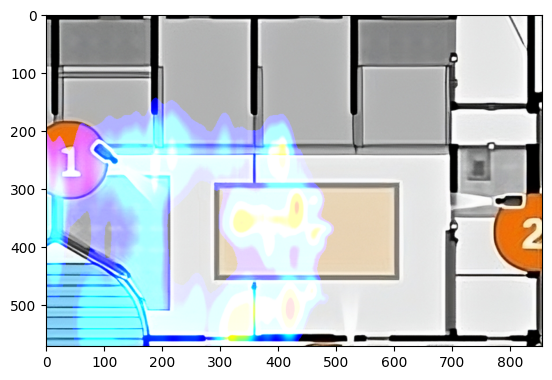

In [11]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_new, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()
